In [ ]:
import numpy as np
from model import Model as custom_model
from Dataset import Dataset
from tensorflow.keras.models import Model
from Pretext_Design import Generation
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers,models

#### Importing the dataset by get_dataset function
  ##### This function accepts two attribute first one is the path of the dataset second one is the your required image size by default its (32,32)

In [ ]:
(x_train,y_train),(x_test,y_test)=Dataset.get_dataset('Test_Data/Brain_Tumor',(96,96))

100%|██████████| 930/930 [00:48<00:00, 19.31it/s]


In [ ]:
#To check the dimenstion and the number of samples
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2451, 96, 96, 3), (2451, 1), (613, 96, 96, 3), (613, 1))

Custom Model class id designed with a contrastive model and an auto encoder model. The constructor takes output as follows:


1.   Shape of the image
2.   Number of class in the dataset
3.   Number of epochs
4.   batch size

Another class is designed for pretext generation such as for making positive and negative pairs and do masking. Construtor takes the output as follows:

1.   Dimension of image
2.   Number of samples that need to be process
3.   Number of class





In [ ]:
model=custom_model(x_train[0].shape,len(np.unique(y_train)),10,32)
preprocessing=Generation(x_train[0].shape,len(x_train),len(np.unique(y_train)))

In [ ]:
#Normalization
x_train=x_train.astype('float32') / 255.0
x_test=x_test.astype('float32') / 255.0


In [ ]:
# Masking the images and getting the auto encoder model
masked_images=x_train*preprocessing.image_masking()
ssl=model.self_supervised_model()

In [ ]:
# Callback function
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=3,
    restore_best_weights=True
)


model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='encoder_model.h5',
    monitor='loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

Pretraining the model without any external levels

In [ ]:
encoder_history=ssl.fit(masked_images,x_train,epochs=20, batch_size=32,
        callbacks=[early_stopping_callback, model_checkpoint_callback])

Epoch 1/20
77/77 [==============================] - ETA: 0s - loss: 0.0124 - accuracy: 0.9298
Epoch 1: loss improved from inf to 0.01239, saving model to encoder_model.h5
77/77 [==============================] - 21s 63ms/step - loss: 0.0124 - accuracy: 0.9298
Epoch 2/20
77/77 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 0.9571
Epoch 2: loss improved from 0.01239 to 0.00434, saving model to encoder_model.h5
77/77 [==============================] - 3s 38ms/step - loss: 0.0043 - accuracy: 0.9571
Epoch 3/20
77/77 [==============================] - ETA: 0s - loss: 0.0039 - accuracy: 0.9592
Epoch 3: loss improved from 0.00434 to 0.00390, saving model to encoder_model.h5
77/77 [==============================] - 3s 38ms/step - loss: 0.0039 - accuracy: 0.9592
Epoch 4/20
77/77 [==============================] - ETA: 0s - loss: 0.0032 - accuracy: 0.9635
Epoch 4: loss improved from 0.00390 to 0.00322, saving model to encoder_model.h5
77/77 [==============================] 

In [ ]:
from sklearn.model_selection import train_test_split
x_test,x_fine_train,y_test,y_fine_train=train_test_split(x_test,y_test,test_size=.2 ,stratify=y_test)

In [ ]:
# How many samples that left for testing and finetuning
x_test.shape,x_fine_train.shape

((490, 96, 96, 3), (123, 96, 96, 3))

Fine tuneing the model using the pretrain encoder model

In [ ]:
ssl.trainable=False
feature_ex=Model(ssl.input,ssl.layers[-3].output)
classification=model.classification_model(feature_ex.output_shape[1:])

In [ ]:
classification.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
fine_tuning_1=classification.fit(feature_ex.predict(x_fine_train),to_categorical(y_fine_train)[:, 1:],epochs=10,batch_size=32)

4/4 [==============================] - 1s 143ms/step
Epoch 1/10
4/4 [==============================] - 1s 54ms/step - loss: 19.9866 - accuracy: 0.4634
Epoch 2/10
4/4 [==============================] - 0s 14ms/step - loss: 6.1032 - accuracy: 0.4065
Epoch 3/10
4/4 [==============================] - 0s 15ms/step - loss: 2.0300 - accuracy: 0.3496
Epoch 4/10
4/4 [==============================] - 0s 14ms/step - loss: 0.7332 - accuracy: 0.6748
Epoch 5/10
4/4 [==============================] - 0s 14ms/step - loss: 0.5530 - accuracy: 0.7642
Epoch 6/10
4/4 [==============================] - 0s 14ms/step - loss: 0.3791 - accuracy: 0.8780
Epoch 7/10
4/4 [==============================] - 0s 15ms/step - loss: 0.3784 - accuracy: 0.8049
Epoch 8/10
4/4 [==============================] - 0s 15ms/step - loss: 0.2831 - accuracy: 0.8537
Epoch 9/10
4/4 [==============================] - 0s 16ms/step - loss: 0.1953 - accuracy: 0.9593
Epoch 10/10
4/4 [==============================] - 0s 12ms/step - loss: 0

In [ ]:
prediction_1=classification.evaluate(feature_ex.predict(x_test),to_categorical(y_test)[:, 1:])

16/16 [==============================] - 0s 10ms/step - loss: 0.7337 - accuracy: 0.7408


**Contrastive model**
Data Preprocessing for contrastive model



> generate_contrastive_pairs can take additional paramenter call number of pairs, by default its set to 2000.




In [ ]:
from sklearn.utils import shuffle


positive_pairs, negative_pairs = preprocessing.generate_contrastive_pairs(x_train, y_train)
y_positive = np.ones(len(positive_pairs))
y_negative = np.zeros(len(negative_pairs))

all_pairs = np.concatenate([positive_pairs, negative_pairs], axis=0)
all_labels = np.concatenate([y_positive, y_negative], axis=0)
all_pairs, all_labels = shuffle(all_pairs, all_labels, random_state=42)

100%|██████████| 2000/2000 [00:00<00:00, 8097.95it/s]


In [ ]:
# call back functions for contrastive model
early_stopping_callback_2 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

model_checkpoint_callback_2 = tf.keras.callbacks.ModelCheckpoint(
    filepath='contrastive_model.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

It might be confusing that what is the role of labels in the training process. all_lebels variable is containing an indication whether the image is from position or negative pairs.

In [ ]:
contrastive_model=model.contrastive_model()
contrative_model_history=contrastive_model.fit([x_train[all_pairs[:, 0]], x_train[all_pairs[:, 1]]], all_labels,
                      epochs=10, batch_size=32, validation_split=0.2,
                      callbacks=[early_stopping_callback, model_checkpoint_callback])


Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 1.4030 - accuracy: 0.5059
Epoch 1: loss did not improve from 0.00123
100/100 [==============================] - 7s 52ms/step - loss: 1.4030 - accuracy: 0.5059 - val_loss: 0.3112 - val_accuracy: 0.4963
Epoch 2/10
 99/100 [============================>.] - ETA: 0s - loss: 0.2816 - accuracy: 0.5578
Epoch 2: loss did not improve from 0.00123
100/100 [==============================] - 4s 37ms/step - loss: 0.2818 - accuracy: 0.5572 - val_loss: 0.2995 - val_accuracy: 0.4988
Epoch 3/10
 99/100 [============================>.] - ETA: 0s - loss: 0.2399 - accuracy: 0.6244
Epoch 3: loss did not improve from 0.00123
100/100 [==============================] - 4s 37ms/step - loss: 0.2392 - accuracy: 0.6263 - val_loss: 0.2944 - val_accuracy: 0.5050
Epoch 4/10
 99/100 [============================>.] - ETA: 0s - loss: 0.1964 - accuracy: 0.7172
Epoch 4: loss did not improve from 0.00123
100/100 [==============================] - 4s 37

Fine Tuning the contrastive model with less training data.

In [ ]:
feature_extract = Model(inputs=contrastive_model.layers[2].input, outputs=contrastive_model.layers[2].output)

x_fine_train_embeddings = feature_extract.predict(x_fine_train)
classifier_model = models.Sequential([
    layers.Dense(256, activation='relu', input_shape=(256,)),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

classifier_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

fine_tuning_2 = classifier_model.fit(x_fine_train_embeddings, to_categorical(y_fine_train)[:, 1:] , epochs=10, batch_size=32)


prediction_2=classifier_model.evaluate(feature_extract.predict(x_test), to_categorical(y_test)[:, 1:] )

4/4 [==============================] - 0s 56ms/step
Epoch 1/10
4/4 [==============================] - 2s 6ms/step - loss: 1.0916 - accuracy: 0.4065
Epoch 2/10
4/4 [==============================] - 0s 5ms/step - loss: 1.0650 - accuracy: 0.4797
Epoch 3/10
4/4 [==============================] - 0s 5ms/step - loss: 1.0753 - accuracy: 0.4715
Epoch 4/10
4/4 [==============================] - 0s 5ms/step - loss: 1.0747 - accuracy: 0.4553
Epoch 5/10
4/4 [==============================] - 0s 5ms/step - loss: 1.0552 - accuracy: 0.4553
Epoch 6/10
4/4 [==============================] - 0s 5ms/step - loss: 1.0754 - accuracy: 0.4634
Epoch 7/10
4/4 [==============================] - 0s 4ms/step - loss: 1.0904 - accuracy: 0.4390
Epoch 8/10
4/4 [==============================] - 0s 4ms/step - loss: 1.0582 - accuracy: 0.4553
Epoch 9/10
4/4 [==============================] - 0s 5ms/step - loss: 1.0545 - accuracy: 0.4634
Epoch 10/10
16/16 [==============================] - 0s 3ms/step - loss: 1.0541 - ac

Plotting graph for comparing the used model in this work.

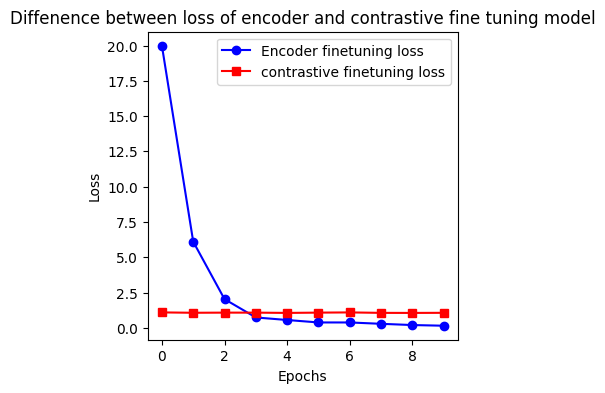

In [ ]:
x=range(len(fine_tuning_1.history['loss']))
y1 = fine_tuning_1.history['loss']
y2 = fine_tuning_2.history['loss']
plt.figure(figsize=(4, 4))
plt.plot(x, y1, label='Encoder finetuning loss', color='blue', marker='o')
plt.plot(x, y2, label='contrastive finetuning loss', color='red', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Diffenence between loss of encoder and contrastive fine tuning model')
plt.legend()
plt.savefig('loss.png', bbox_inches='tight')
plt.show()


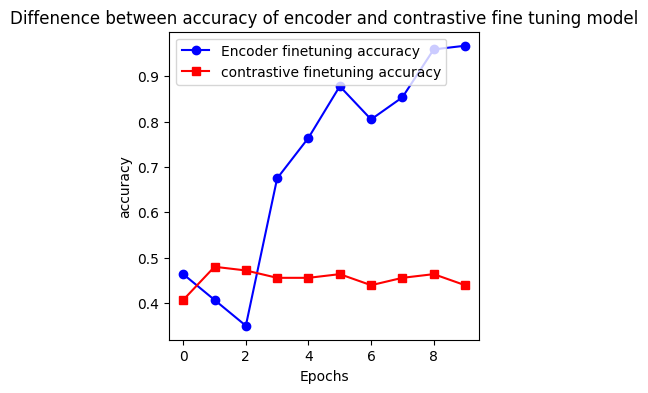

In [ ]:
x=range(len(fine_tuning_1.history['accuracy']))
y1 = fine_tuning_1.history['accuracy']
y2 = fine_tuning_2.history['accuracy']
plt.figure(figsize=(4, 4))
plt.plot(x, y1, label='Encoder finetuning accuracy', color='blue', marker='o')
plt.plot(x, y2, label='contrastive finetuning accuracy', color='red', marker='s')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.title('Diffenence between accuracy of encoder and contrastive fine tuning model')
plt.legend()
plt.savefig('accuracy.png', bbox_inches='tight')
plt.show()

Evaluation on testing data

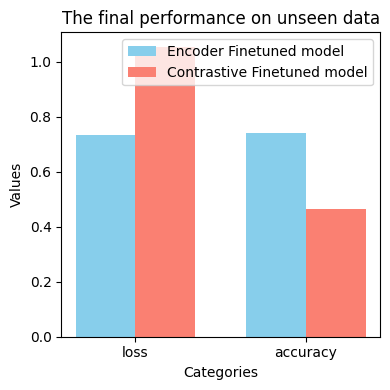

In [ ]:
x = ['loss','accuracy']
values1 = prediction_1
values2 = prediction_2
bar_width = 0.35
x_axis = np.arange(len(x))
plt.figure(figsize=(4, 4))
plt.bar(x_axis - bar_width/2, values1, bar_width, label='Encoder Finetuned model', color='skyblue')
plt.bar(x_axis + bar_width/2, values2, bar_width, label='Contrastive Finetuned model', color='salmon')
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('The final performance on unseen data')
plt.xticks(x_axis, x)
plt.legend()
plt.savefig('evaluation.png', bbox_inches='tight')
plt.tight_layout()
plt.show()



Extra

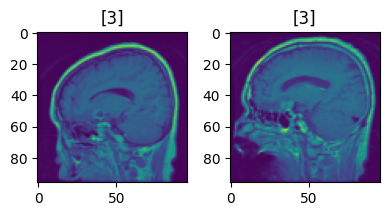

In [ ]:
pair=positive_pairs[10]
image1 = x_train[pair[0]]
image2 =x_train[pair[1]]

fig, axes = plt.subplots(1, 2, figsize=(4, 4))
axes[0].imshow(image1)
axes[0].set_title(y_train[pair[0]])
axes[1].imshow(image2)
axes[1].set_title(y_train[pair[1]])
plt.savefig('positive.png', bbox_inches='tight')
plt.tight_layout()

plt.show()


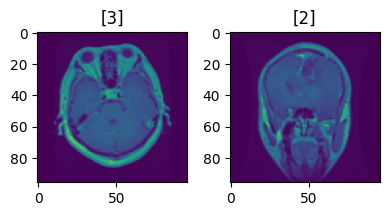

In [ ]:
pair=negative_pairs[10]
image1 = x_train[pair[0]]
image2 =x_train[pair[1]]

fig, axes = plt.subplots(1, 2, figsize=(4, 4))
axes[0].imshow(image1)
axes[0].set_title(y_train[pair[0]])
axes[1].imshow(image2)
axes[1].set_title(y_train[pair[1]])
plt.savefig('negative.png', bbox_inches='tight')
plt.tight_layout()

plt.show()


/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


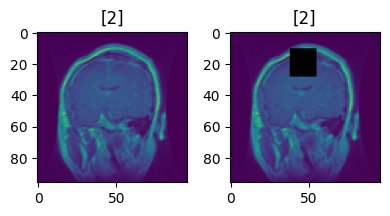

In [ ]:
index=10
image1 =x_train[index]
image2 = masked_images[index]


fig, axes = plt.subplots(1, 2, figsize=(4, 4))
axes[0].imshow(image1)
axes[0].set_title(y_train[index])
axes[1].imshow(image2)
axes[1].set_title(y_train[index])
plt.savefig('masked.png', bbox_inches='tight')
plt.tight_layout()

plt.show()